# Experimenting With Autoscalers

In this notebook, we will be learning about how to experiment with
autoscalers and log and plot different characteristics of the workload
along the way. You can check the `api-test` notebook for information about
how to interact with different APIs used for this project. Here, we will put
all APIs together to monitor and work with all of the required APIs.

In [1]:
master_ip = "192.168.23.88"

deploy_list = [
    "redis-cart",
    "shippingservice",
    "paymentservice",
    "productcatalogservice",
    "emailservice",
    "checkoutservice",
    "recommendationservice",
    "currencyservice",
    "cartservice",
    "adservice",
    # "loadgenerator", # we don't want to scale load generator
    "frontend",
]

# Interating With The APIs

In this section, we will be adding the functionality to interact with different
APIs. We will later on use these functions to perform the experiment and plot
the results.

## Kubernetes API

The first API we will be interacting with is the Kubernetes API. This API is mostly used
for getting or setting the number of pods in a specific deployment.

In [2]:
from kubernetes import client, config
config.load_kube_config()

api_instance = client.AppsV1Api()

def get_replica_and_ready(deployment_name, deployment_ns="default"):
    api_response = api_instance.read_namespaced_deployment(deployment_name, deployment_ns)
    return api_response.status.replicas, api_response.status.ready_replicas

def set_replica_num(rnum, deployment_name, deployment_ns="default"):
    rnum = int(rnum)
    if rnum < 1:
        rnum = 1
    api_response = api_instance.read_namespaced_deployment(deployment_name, deployment_ns)
    api_response.spec.replicas = rnum
    api_instance.patch_namespaced_deployment_scale(deployment_name, deployment_ns, api_response)

# Example usage:
# get_replica_and_ready('frontend')
# set_replica_num(1,'frontend')

In [3]:
def get_all_deployment_kubernetes_count():
    result = {}
    for d in deploy_list:
        counts = get_replica_and_ready(d)
        result[d + '_ordered'] = counts[0]
        result[d + '_ready'] = counts[1]
    return result

get_all_deployment_kubernetes_count()

{'redis-cart_ordered': 1,
 'redis-cart_ready': 1,
 'shippingservice_ordered': 1,
 'shippingservice_ready': 1,
 'paymentservice_ordered': 1,
 'paymentservice_ready': 1,
 'productcatalogservice_ordered': 1,
 'productcatalogservice_ready': 1,
 'emailservice_ordered': 1,
 'emailservice_ready': 1,
 'checkoutservice_ordered': 1,
 'checkoutservice_ready': 1,
 'recommendationservice_ordered': 1,
 'recommendationservice_ready': 1,
 'currencyservice_ordered': 1,
 'currencyservice_ready': 1,
 'cartservice_ordered': 1,
 'cartservice_ready': 1,
 'adservice_ordered': 1,
 'adservice_ready': 1,
 'frontend_ordered': 1,
 'frontend_ready': 1}

## Prometheus API

Prometheus is the monitoring tool that we will be using for this project.
Prometheus allows us to query several monitored metrics like CPU usage,
memory usage, or number of pods.

In [4]:
from prometheus_api_client import PrometheusConnect
prometheus_base = f"http://{master_ip}:9090"

prom = PrometheusConnect(url=prometheus_base, disable_ssl=True)
# Get the list of all the metrics that the Prometheus host scrapes
# (only top 10 is shown)
prom.all_metrics()[:10]

[':kube_pod_info_node_count:',
 ':node_memory_MemAvailable_bytes:sum',
 'ALERTS',
 'ALERTS_FOR_STATE',
 'aggregator_openapi_v2_regeneration_count',
 'aggregator_openapi_v2_regeneration_duration',
 'aggregator_unavailable_apiservice',
 'alertmanager_alerts',
 'alertmanager_alerts_invalid_total',
 'alertmanager_alerts_received_total']

In [5]:
# get pod count
query_pod_count = """count(
        kube_pod_info{namespace="default"}
    ) by (created_by_kind,created_by_name)"""
get_pod_count_query = lambda: prom.custom_query(query=query_pod_count)

def get_pod_count(deploy_name, query_res):
    filtered_res = [{
        'name': q['metric']['created_by_name'],
        'count': int(q['value'][1]),
    } for q in count_q_res]
    for res in filtered_res:
        if res['name'].startswith(deploy_name):
            return res['count']
    # if not found, return -1
    return -1

count_q_res = get_pod_count_query()
get_pod_count('frontend', count_q_res)

1

In [6]:
def get_all_deployment_pod_counts():
    count_q_res = get_pod_count_query()
    deploy_pod_counts = {}
    for d in deploy_list:
        deploy_pod_counts[d] = get_pod_count(d, count_q_res)
    return deploy_pod_counts

get_all_deployment_pod_counts()

{'redis-cart': 1,
 'shippingservice': 1,
 'paymentservice': 1,
 'productcatalogservice': 1,
 'emailservice': 1,
 'checkoutservice': 1,
 'recommendationservice': 1,
 'currencyservice': 1,
 'cartservice': 1,
 'adservice': 1,
 'frontend': 1}

In [38]:
# get workload cpu
query_workload_cpu = """
sum(
  rate(container_cpu_usage_seconds_total{cluster="", namespace="default"}[2m])
* on(namespace,pod)
  group_left(workload, workload_type) namespace_workload_pod:kube_pod_owner:relabel{cluster="", namespace="default", workload_type="deployment"}
) by (workload, workload_type)
"""
get_workload_cpu_query = lambda: prom.custom_query(query=query_workload_cpu)


def get_all_deployment_cpu_usage():
    wl_cpu_res = get_workload_cpu_query()
    # filter results (unit is millicores)
    filtered_cpu_query = { q['metric']['workload']: float(q['value'][1])*1000 for q in wl_cpu_res }
    return filtered_cpu_query

# results are in millicores (1 cpu core is 1000 cpu millicores)
get_all_deployment_cpu_usage()

{'emailservice': 5.434192154018445,
 'checkoutservice': 1.478266293970331,
 'currencyservice': 2.09131904709444,
 'recommendationservice': 5.516561127509798,
 'frontend': 0.08939751476857262,
 'productcatalogservice': 1.674047090406333,
 'redis-cart': 0.5172550250001963,
 'loadgenerator': 1.0694437631693832,
 'shippingservice': 3.607801317171514,
 'cartservice': 3.234218324111804,
 'paymentservice': 2.4239526408664283,
 'adservice': 10.458045221221177}

## Locust API

Locust is the load generator of choice for this project. We will be using
a specific fork of this project called `pacs_locust` which has some added
functionality and reported metrics. We will use the Locust API to change
the number of simulated users throughout the experiment, and fetch the
observed quality of service metrics for evaluation purposes.

In [8]:
import pacs_load_tester as load_tester
# this is the base path for the locust server. don't change this value, just update master_ip on the top of the file.
locust_base = f"http://{master_ip}:8089/"
# get a list of returned metrics
load_tester.get_current_stats(base=locust_base).keys()

dict_keys(['current_max_response_time', 'current_min_response_time', 'current_response_time_average', 'current_response_time_percentile_50', 'current_response_time_percentile_95', 'errors', 'fail_ratio', 'state', 'stats', 'total_average_response_time', 'total_rps', 'user_count'])

## Custom Sensing

Out load testing library allows us to provide a custom sensing function to fetch
custom metrics in addition to the exposed locust metrics. We will be integrating
all deployed monitoring and logging functionality into this function to enable
synchronous metrics to be shown after the experiment.

In [9]:
# first, add a helper function to add prefix to dict keys
def prefix_dict(prefix, dict):
    return {prefix+'_'+k: v for k,v in dict.items()}

# test the function
prefix_dict('test', get_all_deployment_cpu_usage())

{'test_adservice': 11.083884739209356,
 'test_loadgenerator': 1.5931264716104319,
 'test_emailservice': 5.407932621271651,
 'test_checkoutservice': 2.2250212597806716,
 'test_cartservice': 2.5626467912435555,
 'test_currencyservice': 2.2214608206158006,
 'test_recommendationservice': 4.6832902166710255,
 'test_productcatalogservice': 2.1844852539595885,
 'test_redis-cart': 0.8646694455487776,
 'test_shippingservice': 3.776267642100819,
 'test_frontend': 0.3407939343434528,
 'test_paymentservice': 1.4697926499998462}

In [10]:
def custom_sensing():
    result = {}
    result.update(
        prefix_dict('cpu', get_all_deployment_cpu_usage())
    )
    result.update(
        prefix_dict('monitored_count', get_all_deployment_pod_counts())
    )
    result.update(
        prefix_dict('kubernetes', get_all_deployment_kubernetes_count())
    )
    return result

# test custom sensing functionality
custom_sensing()

{'cpu_currencyservice': 2.2214608206158006,
 'cpu_loadgenerator': 1.5931264716104319,
 'cpu_emailservice': 5.407932621271651,
 'cpu_shippingservice': 3.7762676421008194,
 'cpu_frontend': 0.3407939343434528,
 'cpu_paymentservice': 1.4697926499998462,
 'cpu_recommendationservice': 4.6832902166710255,
 'cpu_adservice': 11.083884739209356,
 'cpu_productcatalogservice': 2.1844852539595885,
 'cpu_redis-cart': 0.8646694455487776,
 'cpu_checkoutservice': 2.225021259780672,
 'cpu_cartservice': 2.1625107874996274,
 'monitored_count_redis-cart': 1,
 'monitored_count_shippingservice': 1,
 'monitored_count_paymentservice': 1,
 'monitored_count_productcatalogservice': 1,
 'monitored_count_emailservice': 1,
 'monitored_count_checkoutservice': 1,
 'monitored_count_recommendationservice': 1,
 'monitored_count_currencyservice': 1,
 'monitored_count_cartservice': 1,
 'monitored_count_adservice': 1,
 'monitored_count_frontend': 1,
 'kubernetes_redis-cart_ordered': 1,
 'kubernetes_redis-cart_ready': 1,
 'k

# Experiment With/Without HPA

To outline the difference between using an autoscaler and not using one,
we will be running a sample experiment with and without HPA. To enable/disable
HPA, use the `hpa_enabled` variable defined below:

In [11]:
import time
# stop any previous running experiments and wait for change to take effect
load_tester.stop_test(locust_base)
time.sleep(5)

In [12]:
hpa_enabled = True

# scale everything to 1
for d in deploy_list:
    # !kubectl scale --replicas=1 deploy/{d}
    set_replica_num(1,d)
# making sure there is no hpa running
for d in deploy_list:
    !kubectl delete hpa/{d} > /dev/null 2>&1

if hpa_enabled:
    print('------> HPA Enabled!')
    for d in deploy_list:
        !kubectl autoscale deployment {d} --cpu-percent=50 --min=1 --max=10
    # wait to see if hpa will scale
    time.sleep(10)
    # wait until everything converges
    print('waiting for deployment to converge:')
    while min(get_all_deployment_kubernetes_count().values()) > 1:
        print('.', end='', flush=True)
        time.sleep(1)
    print('deployment converged')
else:
    print('------> HPA Disabled!')

------> HPA Enabled!
horizontalpodautoscaler.autoscaling/redis-cart autoscaled
horizontalpodautoscaler.autoscaling/shippingservice autoscaled
horizontalpodautoscaler.autoscaling/paymentservice autoscaled
horizontalpodautoscaler.autoscaling/productcatalogservice autoscaled
horizontalpodautoscaler.autoscaling/emailservice autoscaled
horizontalpodautoscaler.autoscaling/checkoutservice autoscaled
horizontalpodautoscaler.autoscaling/recommendationservice autoscaled
horizontalpodautoscaler.autoscaling/currencyservice autoscaled
horizontalpodautoscaler.autoscaling/cartservice autoscaled
horizontalpodautoscaler.autoscaling/adservice autoscaled
horizontalpodautoscaler.autoscaling/frontend autoscaled
waiting for deployment to converge:
deployment converged


In [13]:
import pandas as pd
from tqdm.auto import tqdm
import time
tqdm.pandas()

loop_timer = load_tester.TimerClass()
total_timer = load_tester.TimerClass()

user_sequence = [50,100,500,1000,1000,1000,500,100,50]
lt = load_tester.PACSLoadTester(hatch_rate=1000, temp_stat_max_len=60, base=locust_base)
# add the custom sensing function
lt.custom_sensing = custom_sensing
lt.change_count(user_sequence[0])
# wait for changes to take effect
time.sleep(10)
lt.start_capturing()

loop_time_in_secs = load_tester.get_loop_time_in_secs('60s')

loop_timer.tic()
total_timer.tic()

arr_results = []
for i in tqdm(range(len(user_sequence))):
    user_count = user_sequence[i]
    lt.change_count(user_count)
    
    time.sleep(loop_time_in_secs - loop_timer.toc())
    
    loop_timer.tic()
    
    result = lt.get_all_stats()    
    arr_results.append(result)
    
lt.stop_test()

True

In [14]:
# create a folder for results
!mkdir -p results
# parse the results
results = None
for result in arr_results:
    df_result = pd.DataFrame(data=result)
    
    if results is None:
        results = df_result
    else:
        results = results.append(df_result)

results, filename = lt.prepare_results_from_df(results)
# get a list of columns
results.columns

Index(['time', 'current_response_time_percentile_50',
       'current_response_time_percentile_95', 'current_response_time_average',
       'current_max_response_time', 'current_min_response_time',
       'current_fail_per_sec', 'fail_ratio', 'total_rps', 'user_count',
       'avg_response_time', 'current_rps', 'max_response_time',
       'median_response_time', 'min_response_time', 'num_failures',
       'num_requests', 'custom_cpu_loadgenerator', 'custom_cpu_emailservice',
       'custom_cpu_frontend', 'custom_cpu_cartservice', 'custom_cpu_adservice',
       'custom_cpu_productcatalogservice', 'custom_cpu_shippingservice',
       'custom_cpu_checkoutservice', 'custom_cpu_paymentservice',
       'custom_cpu_currencyservice', 'custom_cpu_recommendationservice',
       'custom_cpu_redis-cart', 'custom_monitored_count_redis-cart',
       'custom_monitored_count_shippingservice',
       'custom_monitored_count_paymentservice',
       'custom_monitored_count_productcatalogservice',
       

## Plot The Results

Text(0, 0.5, 'Fail Per Second')

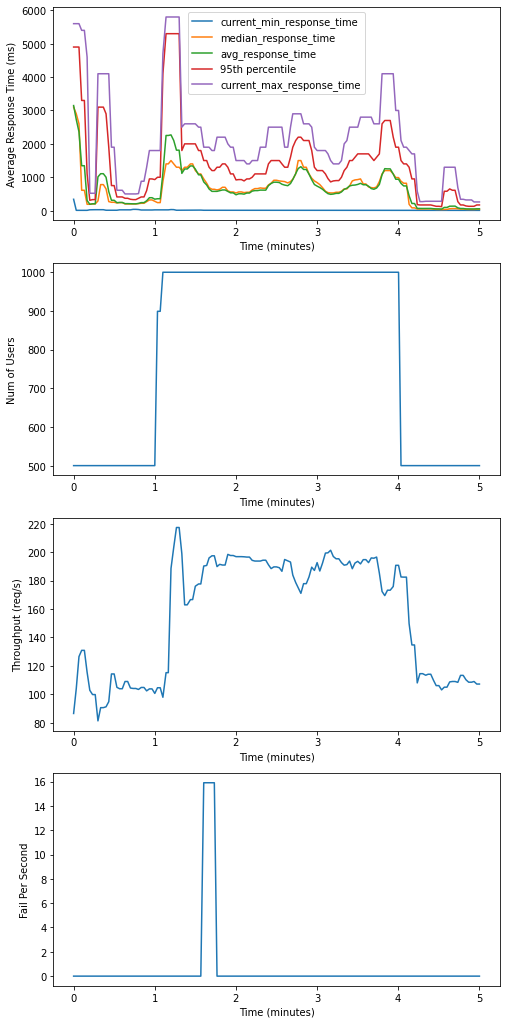

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

res = results

plt.figure(figsize=(8,18))
plt.subplot(411)
plt.plot(res['elapsed_min'], res['current_min_response_time'], label='current_min_response_time')
plt.plot(res['elapsed_min'], res['current_response_time_percentile_50'], label='median_response_time')
plt.plot(res['elapsed_min'], res['current_response_time_average'], label='avg_response_time')
plt.plot(res['elapsed_min'], res['current_response_time_percentile_95'], label='95th percentile')
plt.plot(res['elapsed_min'], res['current_max_response_time'], label='current_max_response_time')

plt.xlabel('Time (minutes)')
plt.ylabel('Average Response Time (ms)')
plt.legend()

plt.subplot(412)
plt.plot(res['elapsed_min'], res['user_count'])
plt.xlabel('Time (minutes)')
plt.ylabel('Num of Users')

plt.subplot(413)
plt.plot(res['elapsed_min'], res['total_rps'])
plt.xlabel('Time (minutes)')
plt.ylabel('Throughput (req/s)')

plt.subplot(414)
plt.plot(res['elapsed_min'], res['current_fail_per_sec'])
plt.xlabel('Time (minutes)')
plt.ylabel('Fail Per Second')

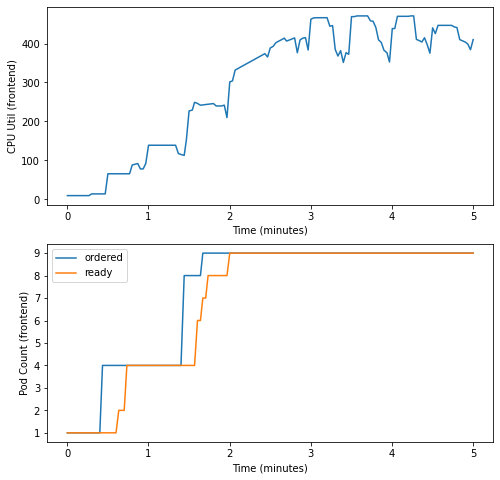

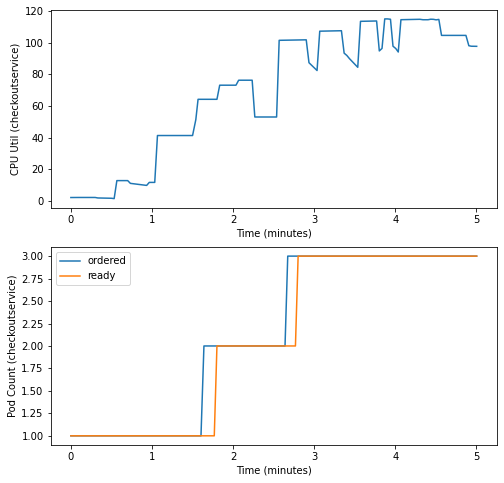

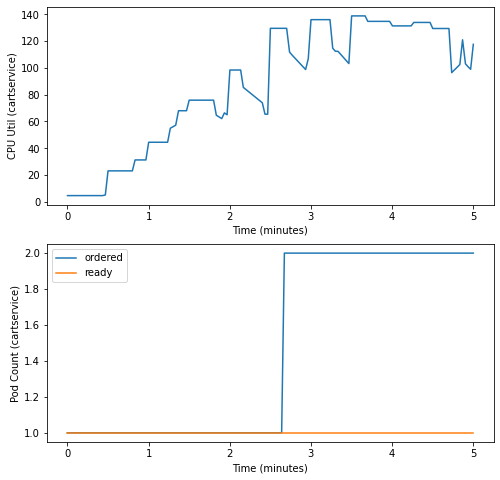

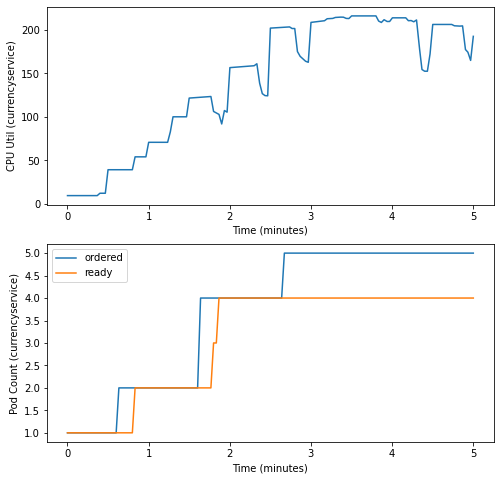

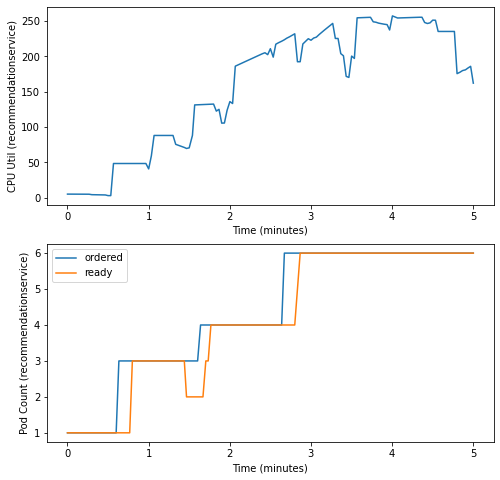

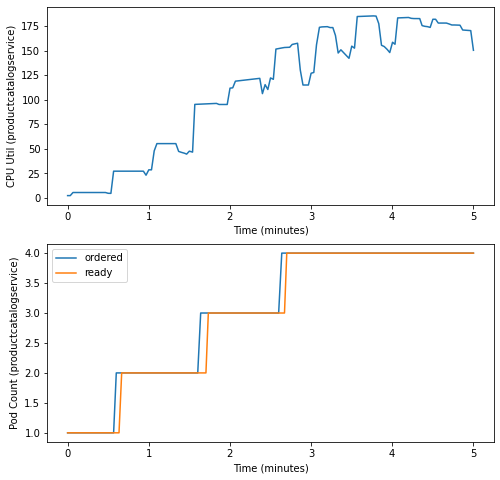

In [16]:
plot_deploy_list = [
    'frontend',
    'checkoutservice',
    'cartservice',
    'currencyservice',
    'recommendationservice',
    'productcatalogservice'
]

for d in plot_deploy_list:
    plt.figure(figsize=(8, 8))
    plt.subplot(211)
    plt.plot(res['elapsed_min'], res[f'custom_cpu_{d}'])
    plt.xlabel('Time (minutes)')
    plt.ylabel(f'CPU Util ({d})')
    plt.subplot(212)
    plt.plot(res['elapsed_min'], res[f'custom_kubernetes_{d}_ordered'], label='ordered')
    plt.plot(res['elapsed_min'], res[f'custom_kubernetes_{d}_ready'], label='ready')
    plt.xlabel('Time (minutes)')
    plt.ylabel(f'Pod Count ({d})')
    plt.legend()

In [17]:
# get the final status
!kubectl get deploy




NAME                    READY   UP-TO-DATE   AVAILABLE   AGE
redis-cart              1/1     1            1           2d
shippingservice         1/1     1            1           2d
paymentservice          1/1     1            1           2d
emailservice            1/1     1            1           2d
adservice               1/1     1            1           2d
loadgenerator           1/1     1            1           2d
frontend                9/9     9            9           2d
currencyservice         4/5     5            4           2d
cartservice             1/2     2            1           2d
productcatalogservice   4/4     4            4           2d
checkoutservice         3/3     3            3           2d
recommendationservice   6/6     6            6           2d
